# Lab 9 - Recommendation Engines

### MovieLens Data

MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.

This data set consists of: * 100,000 ratings (1-5) from 943 users on 1682 movies. * Each user has rated at least 20 movies. * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 1997 through April 22nd, 1998. This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set. Detailed descriptions of the data file can be found at the end of this file.

### Tasks

1. Load the data into the recommender format
2. Build and assess model accuracy
3. Make individual recommendations
4. Try multiple models and compare accuracy
5. Consider how a company could use this

In [3]:
# Install Surpise - a useful library for recommendation engines
#!pip install scikit-surprise

In [86]:
# Load Surprise
from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf
from surprise import Reader

# Load others
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# Exploratory data analysis

# users:
colnames = ['user', 'age', 'sex', 'occupation', 'zipcode']  #: guesses
users = pd.read_csv('u.user', sep = '|', header = None, names = colnames)
users['user'] = users['user'].astype(str)
users['zipcode'] = users['zipcode'].astype(str)
users.describe(include='all')

,user,age,sex,occupation,zipcode
count,943,943.000000,943,943,943
unique,943,NaN,2,21,795
top,368,NaN,M,student,55414
freq,1,NaN,670,196,9
mean,NaN,34.051962,NaN,NaN,NaN
std,NaN,12.192740,NaN,NaN,NaN
min,NaN,7.000000,NaN,NaN,NaN
25%,NaN,25.000000,NaN,NaN,NaN
50%,NaN,31.000000,NaN,NaN,NaN
75%,NaN,43.000000,NaN,NaN,NaN


In [88]:
# Exploratory data analysis

# items:
lineformat = 'user item rating timestamp' #: used by Reader class (below)
colnames = lineformat.split(' ')
items = pd.read_csv('u.data', sep = '\t', header = None, names = colnames)
items.describe(include='all')

,user,item,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


**Task: Plot a histogram of the ratings. Is it skewed? What is the implication?**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000213DC892B70>]], dtype=object)

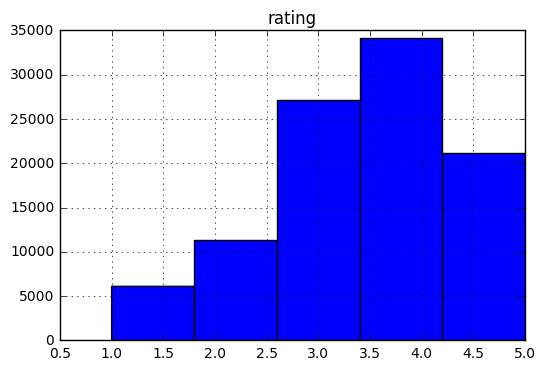

In [89]:
items[['rating']].hist(bins=5)

**Task: How many ratings did a typical user provide?**

Median number of ratings per user = 65.0


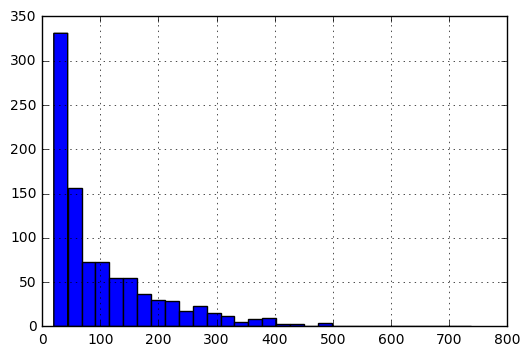

In [90]:
byuser = items.groupby('user').agg({'item': len})
# or:
byuser = items.groupby('user').item.nunique()  # creates a 1D series
print("Median number of ratings per user = {}".format(byuser.median()))
byuser.hist(bins=30)

In [91]:
# 1. Load the data into the recommendation format

# Nb. The object that will be produced for training the recommender is not a data frame
# and doesn't have a head() method
# (which is why we used read_csv() above so that we could look at the raw data).
#
# load the dataset from the library that contains the recommender algo,
# using its Dataset.load_from_file method and Reader class:
reader = Reader(line_format = lineformat, sep = '\t')
#data = Dataset.load_from_file(file_path = '../../data/u.data', reader=reader)
data = Dataset.load_from_file(file_path = 'u.data', reader=reader)

# Split for 5-fold cross-validation:
data.split(n_folds=5)

In [92]:
# 2. Build and assess model accuracy

# We'll use the famous SVD algorithm:
algo = SVD()

# Evaluate performances of our algorithm on the dataset:
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])

print_perf(perf)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9357
MAE:  0.7379
------------
Fold 2
RMSE: 0.9368
MAE:  0.7391
------------
Fold 3
RMSE: 0.9392
MAE:  0.7388
------------
Fold 4
RMSE: 0.9391
MAE:  0.7406
------------
Fold 5
RMSE: 0.9367
MAE:  0.7362
------------
------------
Mean RMSE: 0.9375
Mean MAE : 0.7385
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     0.7379  0.7391  0.7388  0.7406  0.7362  0.7385  
RMSE    0.9357  0.9368  0.9392  0.9391  0.9367  0.9375  


In [93]:
# 3. Make individual recommendations

puid = str(196)  # raw user id (as in the ratings file)
piid = str(302)  # raw item id (as in the ratings file)

# get a prediction for specific users and items:
pred = algo.predict(puid, piid, r_ui=2, verbose=True)

user: 196        item: 302        r_ui = 2.00   est = 4.29   {'was_impossible': False}


In [94]:
# We can look up the movie that we just tested by its index:
#colnames = ['user', 'name']
#items = pd.read_csv('u.item', sep = '|', header = None, names = colnames, usecols = [0, 1])
#print(items.iloc[0])
items['user'] = items['user'].astype(str)
print(items[items.user == piid])

      user  item  rating  timestamp
299    302   322       2  879436875
318    302   303       2  879436785
2593   302   323       2  879436875
2858   302   245       2  879436911
3967   302   309       2  879436820
4826   302   328       3  879436844
9848   302   307       4  879436739
10387  302   879       2  879436960
10611  302   270       2  879436785
14758  302   258       3  879436739
15594  302   299       2  879436932
32327  302   301       4  879436820
32747  302   680       2  879437035
33530  302   988       2  879436875
43238  302   748       1  879436739
50283  302   294       1  879436911
55280  302   358       3  879436981
58767  302   289       3  879436874
81824  302   271       4  879436911
84234  302   333       3  879436785
87380  302   266       2  879436981


In [95]:
# 4. Try multiple models and compare accuracy

# Try at least 3 of the models mentioned below:
# random_pred.NormalPredictor    Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
# baseline_only.BaselineOnly    Algorithm predicting the baseline estimate for given user and item.
# knns.KNNBasic    A basic collaborative filtering algorithm.
# knns.KNNWithMeans    A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
# knns.KNNBaseline    A basic collaborative filtering algorithm taking into account a baseline rating.
# matrix_factorization.SVD    The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.
# matrix_factorization.SVDpp    The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
# matrix_factorization.NMF    A collaborative filtering algorithm based on Non-negative Matrix Factorization.
# slope_one.SlopeOne    A simple yet accurate collaborative filtering algorithm.
# co_clustering.CoClustering    A collaborative filtering algorithm based on co-clustering.


# Here's how to run Non-Negative Matrix Factorisiation
from surprise import NMF

algo.NMF = NMF()
perf.NMF = evaluate(algo.NMF, data, measures=['RMSE', 'MAE'])
print_perf(perf.NMF)

Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 0.9615
MAE:  0.7561
------------
Fold 2
RMSE: 0.9648
MAE:  0.7595
------------
Fold 3
RMSE: 0.9688
MAE:  0.7598
------------
Fold 4
RMSE: 0.9668
MAE:  0.7602
------------
Fold 5
RMSE: 0.9579
MAE:  0.7518
------------
------------
Mean RMSE: 0.9639
Mean MAE : 0.7575
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     0.7561  0.7595  0.7598  0.7602  0.7518  0.7575  
RMSE    0.9615  0.9648  0.9688  0.9668  0.9579  0.9639  


In [39]:
# Here's how to run NormalPredictor
from surprise import NormalPredictor

algo.NormalPredictor = NormalPredictor()
perf.NormalPredictor = evaluate(algo.NormalPredictor, data, measures=['RMSE', 'MAE'])
print_perf(perf.NormalPredictor)

Evaluating RMSE, MAE of algorithm NormalPredictor.

------------
Fold 1
RMSE: 1.5211
MAE:  1.2248
------------
Fold 2
RMSE: 1.5179
MAE:  1.2160
------------
Fold 3
RMSE: 1.5221
MAE:  1.2236
------------
Fold 4
RMSE: 1.5235
MAE:  1.2263
------------
Fold 5
RMSE: 1.5222
MAE:  1.2235
------------
------------
Mean RMSE: 1.5213
Mean MAE : 1.2228
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     1.2248  1.2160  1.2236  1.2263  1.2235  1.2228  
RMSE    1.5211  1.5179  1.5221  1.5235  1.5222  1.5213  


In [102]:

from surprise import KNNWithMeans

algo.KNNWithMeans = KNNWithMeans(min_k=10)
perf.KNNWithMeans = evaluate(algo.KNNWithMeans, data, measures=['RMSE', 'MAE'])
print_perf(perf.KNNWithMeans)

Evaluating RMSE, MAE of algorithm KNNWithMeans.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9511
MAE:  0.7483
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9503
MAE:  0.7495
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9560
MAE:  0.7520
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9582
MAE:  0.7558
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9507
MAE:  0.7491
------------
------------
Mean RMSE: 0.9533
Mean MAE : 0.7509
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     0.7483  0.7495  0.7520  0.7558  0.7491  0.7509  
RMSE    0.9511  0.9503  0.9560  0.9582  0.9507  0.9533  


In [103]:

from surprise import SVDpp

algo.SVDpp = SVDpp()
perf.SVDpp = evaluate(algo.SVDpp, data, measures=['RMSE', 'MAE'])
print_perf(perf.SVDpp)

Evaluating RMSE, MAE of algorithm SVDpp.

------------
Fold 1
RMSE: 0.9189
MAE:  0.7197
------------
Fold 2
RMSE: 0.9152
MAE:  0.7175
------------
Fold 3
RMSE: 0.9182
MAE:  0.7182
------------
Fold 4
RMSE: 0.9234
MAE:  0.7244
------------
Fold 5
RMSE: 0.9192
MAE:  0.7209
------------
------------
Mean RMSE: 0.9190
Mean MAE : 0.7201
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     0.7197  0.7175  0.7182  0.7244  0.7209  0.7201  
RMSE    0.9189  0.9152  0.9182  0.9234  0.9192  0.9190  


In [107]:
#puid = str(196)  # raw user id (as in the ratings file)
#piid = str(302)  # raw item id (as in the ratings file)

# get a prediction for specific users and items:
pred = algo.SVDpp.predict(puid, piid, r_ui=2, verbose=True)

user: 196        item: 302        r_ui = 2.00   est = 3.91   {'was_impossible': False}


In [105]:

from surprise import NMF

algo.NMF = NMF()
perf.NMF = evaluate(algo.NMF, data, measures=['RMSE', 'MAE'])
print_perf(perf.NMF)

Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 0.9650
MAE:  0.7576
------------
Fold 2
RMSE: 0.9624
MAE:  0.7584
------------
Fold 3
RMSE: 0.9681
MAE:  0.7597
------------
Fold 4
RMSE: 0.9685
MAE:  0.7608
------------
Fold 5
RMSE: 0.9639
MAE:  0.7580
------------
------------
Mean RMSE: 0.9656
Mean MAE : 0.7589
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     0.7576  0.7584  0.7597  0.7608  0.7580  0.7589  
RMSE    0.9650  0.9624  0.9681  0.9685  0.9639  0.9656  


In [108]:
# get a prediction for specific users and items:
pred = algo.NMF.predict(puid, piid, r_ui=2, verbose=True)

user: 196        item: 302        r_ui = 2.00   est = 3.55   {'was_impossible': False}


In [106]:

from surprise import CoClustering

algo.CoClustering = CoClustering()
perf.CoClustering = evaluate(algo.CoClustering, data, measures=['RMSE', 'MAE'])
print_perf(perf.CoClustering)

Evaluating RMSE, MAE of algorithm CoClustering.

------------
Fold 1
RMSE: 0.9644
MAE:  0.7537
------------
Fold 2
RMSE: 0.9663
MAE:  0.7550
------------
Fold 3
RMSE: 0.9705
MAE:  0.7599
------------
Fold 4
RMSE: 0.9681
MAE:  0.7577
------------
Fold 5
RMSE: 0.9609
MAE:  0.7536
------------
------------
Mean RMSE: 0.9660
Mean MAE : 0.7560
------------
------------
        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
MAE     0.7537  0.7550  0.7599  0.7577  0.7536  0.7560  
RMSE    0.9644  0.9663  0.9705  0.9681  0.9609  0.9660  


In [109]:
# get a prediction for specific users and items:
pred = algo.CoClustering.predict(puid, piid, r_ui=2, verbose=True)

user: 196        item: 302        r_ui = 2.00   est = 4.40   {'was_impossible': False}


##### 5. Consider how a company could use this

How might a company use a recommendation like this in practice? Write a few paragraphs covering how they could use the above covering:
- How the algorithm works?
- What data would be used?
- How would we know if it's working?
- What is the benefit of using an algorithm over this over just recommending the most popular films overall?